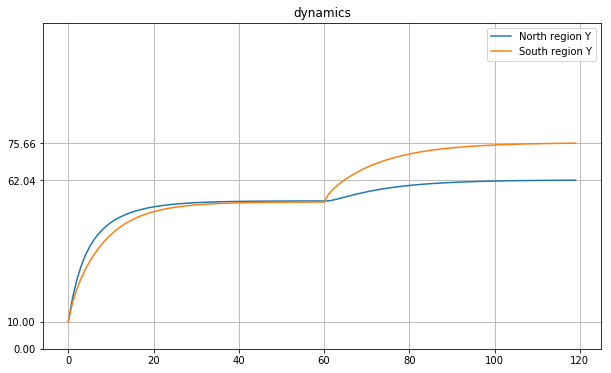

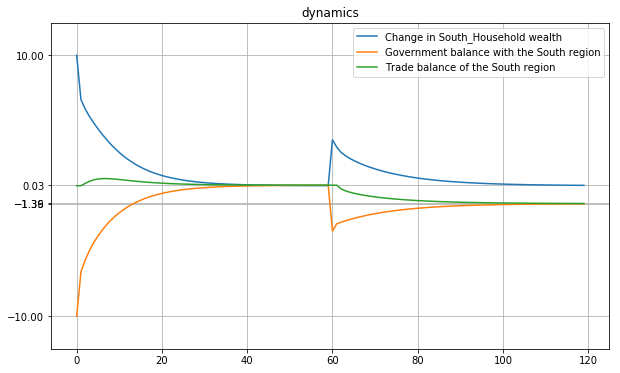

Enter the period to show the balance sheet and transaction matrix:2

Balance Sheet at period:  1
                    North Household    South Household    Production    Government    Central Bank    Sum
------------------  -----------------  -----------------  ------------  ------------  --------------  -----
Cash Money          13.73              15.45              0.00          0.00          -29.18          0.00
Bills               2.51               1.15               0.00          -32.84        29.18           0.00
Balance(net worth)  -16.24             -16.60             0.00          32.84         0.00            0.00
sum                 0.00               0.00               0.00          0.00          0.00            0.00

Transaction flow matrix at period:  1
----------------------  ---------  ----------  ---------  ----------  ----------  -------  -----
                        North      North       South      South                   Central
                        Household  

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun  8 22:00:21 2017
Last modified on Thu Jun  8 22:00:57 2017

@author: Patrick X. Li

@email: xihao.li@gmail.com
"""



"""
Methods used in the following codes
"""
Error_tolerance = 0.001;

def round_2(n1 ):
    if np.isscalar(n1):
        return np.round(  int( n1*1000 ) /1000, 2 );
    else:
        n2 = np.array(n1) * 1000;
        return np.round(  n2.astype(int) /1000, 2 );


def scalar_approximate_equal(n1, n2):
    if np.isscalar(n1) and np.isscalar(n2):
        if n2 != 0:
            return (abs(n1/n2 - 1) < Error_tolerance)
        elif n1 != 0:
            return (abs(n2/n1 - 1) < Error_tolerance)
        else:
            return True
    else:
        return False

#### Model REG = two region economy ####
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 6



"""
simulation parameter
"""
script_file_full_name = os.path.basename(sys.argv[0]);
script_file_name =  os.path.splitext(script_file_full_name)[0] + "_";
    
end_periods = 120
unit_test_activate = 0;
"""
Economic system variables
"""
theta = 0.2;

## region North
alpha_1N = 0.6;
alpha_2N = 0.4;

lambda_0N = 0.3; # portion of expected net worth going to Household's treasury bill demand
lambda_1N = 0.6; # sensitive parameter of Household's treasury bill demand 
                 # on the rate of return on treasury bills
lambda_2N = 0.1; # sensitive parameter of Household's treasury bill demand 
                 # on the level of disposable income relative to Household's net worth
mu_N = 0.1; # parameter used to decide how much to import

## region South   
alpha_1S = 0.5;
alpha_2S = 0.3;

lambda_0S = 0.2; # portion of expected net worth going to Household's treasury bill demand
lambda_1S = 0.5; # sensitive parameter of Household's treasury bill demand 
                # on the rate of return on treasury bills
lambda_2S = 0.2; # sensitive parameter of Household's treasury bill demand 
                # on the level of disposable income relative to Household's net worth
mu_S = 0.1; # parameter used to decide how much to import

initial_G = 20;
incre_GS = 10; # parameter for experiment to increase the government spending in South region
                
class Household:
    def __init__(self):        
        """
        Stock variable in Balance Sheet
        """
        self.H = np.zeros(end_periods); # Household's money demand
        self.B = np.zeros(end_periods); # Household's treasury bill demand
        self.V = np.zeros(end_periods); # Household's net worth
        """
        Flow variables in Transactions-flow matrix
        """   
        self.C = np.zeros(end_periods); # Household's consumption demand
        self.Y = np.zeros(end_periods); # Household's income in aggregate demand side
        self.YD = np.zeros(end_periods); # Household's disposable income in aggregate demand side
        self.YD_e = np.zeros(end_periods); # Household's expectation on disposable income in aggregate demand side
        self.V_e = np.zeros(end_periods); # Household's expectation on Household's net worth
        self.T = np.zeros(end_periods); # Household's tax supply
        self.delta_H = np.zeros(end_periods); # change of Household's money demand
        self.delta_B = np.zeros(end_periods); # change of Household's treasury bill demand
        
class Production:
    def __init__(self):     
        """
        Flow variables in Transactions-flow matrix
        """       
        self.C = np.zeros(end_periods); # Production's consumption supply
        self.G = np.zeros(end_periods); # Production's Government spending supply
        self.IM = np.zeros(end_periods); # Production's import from other region
        self.X = np.zeros(end_periods); # Production's export to other region
        self.Y = np.zeros(end_periods); # Production's production in aggregate supply side
        self.Y_e = np.zeros(end_periods); # Production's expectation on production in aggregate supply side, used to decide how much to import

class Government:
    """
    Stock variable in Balance Sheet
    """    
    B = np.zeros(end_periods); # Government's treasury total bill supply
    BN = np.zeros(end_periods); # Government's treasury bill supply to North_Household
    BS = np.zeros(end_periods); # Government's treasury bill supply to South_Household
    BCB = np.zeros(end_periods); # Government's treasury bill supply to CentralBank
    V = np.zeros(end_periods); # Government's net worth    
    """
    Flow variables in Transactions-flow matrix
    """   
    G = np.zeros(end_periods); # Government's spending demand
    GN = np.zeros(end_periods); # Government's spending demand toward North_Production
    GS = np.zeros(end_periods); # Government's spending demand toward South_Production
    IP = np.zeros(end_periods); # Government's interest payment for government bills
    IPN = np.zeros(end_periods); # Government's interest payment for government bills held by North Household
    IPS = np.zeros(end_periods); # Government's interest payment for government bills held by South Household
    CB_P = np.zeros(end_periods); # Government's receiving Central Bank's profit
    T = np.zeros(end_periods); # Government's tax demand
    delta_B = np.zeros(end_periods); # change of Government's treasury bill supply
    """
    Economic variables
    """
    r = np.ones(end_periods) * 0.1; # Government's government bill interest rate

class CentralBank:
    """
    Stock variable in Balance Sheet
    """
    H = np.zeros(end_periods); # Central Bank's money supply
    HN = np.zeros(end_periods); # Central Bank's money supply to North_Household
    HS = np.zeros(end_periods); # Central Bank's money supply to South_Household   
    B = np.zeros(end_periods); # Central Bank's treasury bill demand
    V = np.zeros(end_periods); # Central Bank's net worth
    """
    Flow variables in Transactions-flow matrix
    """     
    IP = np.zeros(end_periods); # Central Bank's interest payment
    P = np.zeros(end_periods); # Central Bank's profit
    delta_H = np.zeros(end_periods); # change of Central Bank's money supply
    delta_B = np.zeros(end_periods); # change of Central Bank's treasury bill demand

"""
Two regions with two types of Household and two types of Production
"""
North_Household = Household();
South_Household = Household();
North_Production = Production();
South_Production = Production();
    
#== initialize the value of YD[0] ==#
Government.G[0] = initial_G;
## Government distributes its spending among 2 regions Production
Government.GN[0] = Government.G[0]/2;
Government.GS[0] = Government.G[0] -  Government.GN[0];
## 2 region Production produces government spending
North_Production.G[0] = Government.GN[0];
South_Production.G[0] = Government.GS[0];

## Government issues treasury bills to supply government spending
Government.B[0] = Government.G[0]; # Government issue treasury bill to support its government spending
Government.delta_B[0] = Government.B[0] - 0.0; # Government admits its change of treasury bills 
## Government's treasury bills are distributed among 2 regions Household and CentralBank
Government.BN[0] = 0; # Government supplies treasury bill on North_Household's demand 
Government.BS[0] = 0; # Government supplies treasury bill on Sorth_Household's demand 
CentralBank.B[0] = Government.B[0] - ( Government.BN[0] + Government.BS[0] ); # Central Bank buys all the outstanding treasury bills issued by government
CentralBank.delta_B[0] = CentralBank.B[0] - 0.0;
"""
CentralBank can decide how to distribute H to North_Household and South_Household
"""
CentralBank.H[0] = CentralBank.B[0]; # CentralBank supplies high-power money to fit CentralBank's treasury bills holding

## 2 regions Household realizes its income = production
North_Household.Y[0] = Government.GN[0] + North_Household.C[0]; 
South_Household.Y[0] = Government.GS[0] + South_Household.C[0]; 
## 2 regions Household demands the increment of high-power money = its income
North_Household.delta_H[0] = North_Household.Y[0];
South_Household.delta_H[0] = South_Household.Y[0];
## 2 regions Household realizes its high-power money stock after the increment of high-power money demand
North_Household.H[0] = 0.0 + North_Household.delta_H[0];
South_Household.H[0] = 0.0 + South_Household.delta_H[0];
## CentralBank supplies 2 regions high-power money demand
CentralBank.HN[0] = North_Household.H[0];
CentralBank.HS[0] = South_Household.H[0];
CentralBank.delta_H[0] = North_Household.delta_H[0] + South_Household.delta_H[0];

## 2 regions Household disposable income is equal to income - tax
North_Household.YD[0] = North_Household.Y[0] - theta * North_Household.Y[0];
South_Household.YD[0] = South_Household.Y[0] - theta * South_Household.Y[0];
## 2 regions Production realizes its supply according to demand
North_Production.Y[0] = North_Production.C[0] + North_Production.G[0] + North_Production.X[0] - North_Production.IM[0];
South_Production.Y[0] = South_Production.C[0] + South_Production.G[0] + South_Production.X[0] - South_Production.IM[0];
## 2 regions Household updates its net worth
North_Household.V[0] = North_Household.H[0] + North_Household.B[0];
South_Household.V[0] = South_Household.H[0] + South_Household.B[0];
## Government updates its net worth
Government.V[0] = Government.B[0];
## CentralBank updates its net worth
CentralBank.V[0] = - CentralBank.H[0] + CentralBank.B[0];

for t in range(1,end_periods):

    """
    Experiment:
    when t >= 60, South_Household reduces its liquidity preference, by increasing lambda_0S by 400%
    """
    if t == 59:
        lambda_0S = lambda_0S * 4.0;
    """
    Government decides its spending
    """
    Government.G[t] = initial_G;
    """
    Government decides how to distribute spending in 2 regions    
    """
    Government.GN[t] = initial_G/2;
    Government.GS[t] = Government.G[t] - Government.GN[t];
    
        
        
    """
    2 regions Household makes expectation on disposable income: YD_e
    """
    North_Household.YD_e[t] = North_Household.YD[t-1]; # Household's expectation on its YD
    South_Household.YD_e[t] = South_Household.YD[t-1]; # Household's expectation on its YD
    """
    Based on expectation, 2 regions Household decides demand for consumption
    """
    North_Household.C[t] = alpha_1N * North_Household.YD_e[t] + alpha_2N * North_Household.V[t-1]; # Household's consumption demand, based on its expectation on    
    South_Household.C[t] = alpha_1S * South_Household.YD_e[t] + alpha_2S * South_Household.V[t-1]; # Household's consumption demand, based on its expectation on    
    """
    2 regions Household makes expectation on net worth: V_e
    """    
    North_Household.V_e[t] = North_Household.V[t-1] + ( North_Household.YD_e[t] - North_Household.C[t] ); # expectational rule of Household's net worth 
    South_Household.V_e[t] = South_Household.V[t-1] + ( South_Household.YD_e[t] - South_Household.C[t] ); # expectational rule of Household's net worth 
    """
    Based on expectation, 2 regions Household decides demand for treasury bill, 
    demand for money: B and H
    """
    North_Household.B[t] = lambda_0N * North_Household.V_e[t] + lambda_1N * Government.r[t] * North_Household.V_e[t] - lambda_2N * North_Household.YD_e[t];
    South_Household.B[t] = lambda_0S * South_Household.V_e[t] + lambda_1S * Government.r[t] * South_Household.V_e[t] - lambda_2S * South_Household.YD_e[t];
    
    North_Household.H[t] = North_Household.V_e[t] - North_Household.B[t];
    South_Household.H[t] = South_Household.V_e[t] - South_Household.B[t];
    """
    2 region Production expects how much to import based on previous total production
    """
    North_Production.Y_e[t] = North_Production.Y[t-1];
    South_Production.Y_e[t] = South_Production.Y[t-1];
    """
    2 region Production decides how much to import from other region
    """
    North_Production.IM[t] = mu_N * North_Production.Y_e[t];
    South_Production.IM[t] = mu_S * South_Production.Y_e[t];
    """
    Production realizes supply = demand
    """
    North_Production.G[t] = Government.GN[t];
    South_Production.G[t] = Government.GS[t];
    
    North_Production.C[t] = North_Household.C[t];
    South_Production.C[t] = South_Household.C[t];
    
    North_Production.X[t] = South_Production.IM[t];
    South_Production.X[t] = North_Production.IM[t];

    North_Production.Y[t] = North_Production.G[t] + North_Production.C[t] + North_Production.X[t] - North_Production.IM[t];
    South_Production.Y[t] = South_Production.G[t] + South_Production.C[t] + South_Production.X[t] - South_Production.IM[t];
    """
    2 region Household realizes its production, tax payment                                       
    """
    North_Household.Y[t] = North_Production.Y[t];
    South_Household.Y[t] = South_Production.Y[t];
    
    North_Household.T[t] = theta * ( North_Household.Y[t] + Government.r[t-1] * North_Household.B[t-1] );
    South_Household.T[t] = theta * ( South_Household.Y[t] + Government.r[t-1] * South_Household.B[t-1] );
    """
    Government collects tax
    """
    Government.T[t] = North_Household.T[t] + South_Household.T[t];
    """
    Household realizes its disposable income and net worth                                 
    """
    North_Household.YD[t] = North_Household.Y[t] - North_Household.T[t] + Government.r[t-1] * North_Household.B[t-1];
    South_Household.YD[t] = South_Household.Y[t] - South_Household.T[t] + Government.r[t-1] * South_Household.B[t-1];
    North_Household.V[t] = North_Household.V[t-1] + ( North_Household.YD[t] - North_Household.C[t] );
    South_Household.V[t] = South_Household.V[t-1] + ( South_Household.YD[t] - South_Household.C[t] );
    """
    2 region Household adjusts, at the end of period, any discrepency 
    between realized net worth and treasury bill demand, 
    putting it as money demand 
    """
    North_Household.H[t] = North_Household.V[t] - North_Household.B[t]; 
    South_Household.H[t] = South_Household.V[t] - South_Household.B[t]; 
    
    North_Household.delta_H[t] = North_Household.H[t] - North_Household.H[t-1];
    South_Household.delta_H[t] = South_Household.H[t] - South_Household.H[t-1];    
    """
    Government decides its new level of treasury bill    
    """
    CentralBank.P[t] = Government.r[t-1] * CentralBank.B[t-1];
    Government.CB_P[t] = CentralBank.P[t];    
    Government.delta_B[t] = (Government.G[t] + Government.r[t-1] * Government.B[t-1]) - (Government.T[t] + Government.CB_P[t]);
    Government.B[t] = Government.B[t-1] + Government.delta_B[t];
    Government.V[t] = Government.B[t];    
    """
    Government computes its interest payment for treasury bills, only for data recording
    """
    Government.IP[t] = Government.r[t-1] * Government.B[t-1];
    Government.IPN[t] = Government.r[t-1] * North_Household.B[t-1];
    Government.IPS[t] = Government.r[t-1] * South_Household.B[t-1];  
    # unit test on stock-flow consistency
    if unit_test_activate == 1:
        if scalar_approximate_equal(Government.IP[t] , Government.IPN[t] + Government.IPS[t] + Government.r[t-1] * CentralBank.B[t-1] ):
            print('Consistency check: Government interest payment on treasury bills == interest payment to North Household + interest payment to South Household');
        else:
            print('Warning! Government interest payment on treasury bills == interest payment to North Household + interest payment to South Household INconsistency!');     
    """
    CentralBank collects the residual of treasury bill in the market:
    the difference between Government's bill supply and 2 region Household's bill demand
    """
    CentralBank.B[t] = Government.B[t] - North_Household.B[t] - South_Household.B[t];
    """
    CentraBank decides its new level of money supply based on its change of treasury bill bought in
    """    
    CentralBank.delta_B[t] = CentralBank.B[t] - CentralBank.B[t-1];
    CentralBank.delta_H[t] = CentralBank.delta_B[t];
    CentralBank.H[t] = CentralBank.H[t-1] + CentralBank.delta_H[t];
    """
    2 region Household computes its change of treasury bill, to check stock-flow consistency 
    """
    North_Household.delta_B[t] = North_Household.B[t] - North_Household.B[t-1];
    South_Household.delta_B[t] = South_Household.B[t] - South_Household.B[t-1];
    
    # unit test on stock-flow consistency
    if unit_test_activate == 1:
        if scalar_approximate_equal(Government.delta_B[t] , North_Household.delta_B[t] + South_Household.delta_B[t] + CentralBank.delta_B[t] ):
            print('Consistency check: change of Bill supply == change of Bill demand');
        else:
            print('Warning! change of Bill supply == change of Bill demand INconsistency!'); 

# plot 2 region Household expectation on disposable income, realized disposable income, 
# and total income == GDP in demand side
plot_period = end_periods + 1
plt.figure()
plt.plot(North_Household.Y, label = 'North region Y')
plt.plot(South_Household.Y, label = 'South region Y')
plt.title('dynamics')
plt.legend(['North region Y', 'South region Y'], loc=0) # legend automatically in the best location
plt.ylim(0, 110)
extraticks=[0, np.min(North_Household.Y), North_Household.Y[end_periods-1], South_Household.Y[end_periods-1] ]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.yticks(extraticks)
plt.grid()
plt.savefig(script_file_name + 'fig_01.jpg') 
plt.show()

South_Household_delta_V = np.diff( np.insert(South_Household.V ,0, 0.0 ) )

plot_period = end_periods + 1
plt.figure()
plt.plot(South_Household_delta_V, label = 'Change in South_Household wealth')
plt.plot(-(Government.GS + Government.IPS - South_Household.T), label = 'Government balance with the South region')
plt.plot(South_Production.X - South_Production.IM, label = 'Trade balance of the South region')
plt.title('dynamics')
plt.legend(['Change in South_Household wealth', 'Government balance with the South region', 'Trade balance of the South region'], loc=0) # legend automatically in the best location
extraticks=[np.max(South_Household_delta_V), South_Household_delta_V[end_periods-1], np.min(-(Government.GS + Government.IPS - South_Household.T)), -( Government.GS[end_periods-1] + Government.IPS[end_periods-1] - South_Household.T[end_periods-1] ), South_Production.X[end_periods-1] - South_Production.IM[end_periods-1] ]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.yticks(extraticks)
plt.grid()
plt.savefig(script_file_name + 'fig_02.jpg') 
plt.show()

while True:
    table_periods = int(input('Enter the period to show the balance sheet and transaction matrix:'))
    if table_periods > end_periods + 1:
        table_periods = end_periods;
     
    BS_headers = [" ", "North Household", "South Household", "Production", "Government", "Central Bank", "Sum"]
    # balance sheet table
    bs_table = [["Cash Money", North_Household.H[table_periods-1], South_Household.H[table_periods-1], 0.0, 0.0, - CentralBank.H[table_periods-1], sum( [ North_Household.H[table_periods-1], South_Household.H[table_periods-1], - CentralBank.H[table_periods-1] ] )], 
                ["Bills", North_Household.B[table_periods-1], South_Household.B[table_periods-1], 0, - Government.B[table_periods-1], + CentralBank.B[table_periods-1], sum([ North_Household.B[table_periods-1], South_Household.B[table_periods-1], 0, - Government.B[table_periods-1], + CentralBank.B[table_periods-1] ])  ],
                ["Balance(net worth)", - North_Household.V[table_periods-1],  - South_Household.V[table_periods-1], 0.0, +Government.V[table_periods-1], 0.0 , sum([ - North_Household.V[table_periods-1],  - South_Household.V[table_periods-1], 0.0, +Government.V[table_periods-1]  ])  ],
                ["sum", sum([ North_Household.H[table_periods-1],  North_Household.B[table_periods-1], - North_Household.V[table_periods-1] ]), sum([ South_Household.H[table_periods-1],  South_Household.B[table_periods-1], - South_Household.V[table_periods-1] ]), 0.0, sum( [ - Government.B[table_periods-1], +Government.V[table_periods-1] ] ), sum([- CentralBank.H[table_periods-1], + CentralBank.B[table_periods-1]  ]), sum([ sum([ North_Household.H[table_periods-1],  North_Household.B[table_periods-1], - North_Household.V[table_periods-1] ]), sum([ South_Household.H[table_periods-1],  South_Household.B[table_periods-1], - South_Household.V[table_periods-1] ]),   0.0, sum( [ - Government.B[table_periods-1], +Government.V[table_periods-1] ] ), sum([- CentralBank.H[table_periods-1], + CentralBank.B[table_periods-1]  ]) ])  ]
                ]
    print("\nBalance Sheet at period: ", table_periods-1)
    print(tabulate(bs_table, BS_headers, floatfmt=".2f", numalign="left") )
    # transaction flow table
    
    sum_row_Consumption = round_2(sum([ round_2(-North_Household.C[table_periods-1]),  round_2(+North_Production.C[table_periods-1]),  round_2(-South_Household.C[table_periods-1]),  round_2(+South_Production.C[table_periods-1]) ]))
    sum_row_Govt_exp = round_2(sum([ round_2( +North_Production.G[table_periods-1] ), round_2( +South_Production.G[table_periods-1] ), round_2( - ( Government.GN[table_periods-1] + Government.GS[table_periods-1] ) ) ]))                   
    sum_row_North_export = round_2(sum([  round_2( +North_Production.X[table_periods-1] ), round_2( -South_Production.IM[table_periods-1] ) ]))
    sum_row_South_export = round_2(sum([round_2( -North_Production.IM[table_periods-1] ), round_2( +South_Production.X[table_periods-1] ) ]))   
    sum_row_GDP = round_2(sum([ round_2(North_Household.Y[table_periods-1] ), round_2( -North_Production.Y[table_periods-1] ),  round_2(South_Household.Y[table_periods-1] ), round_2( -South_Production.Y[table_periods-1] ) ]))
    sum_row_Interest_payments = round_2(sum([ round_2( + Government.r[table_periods-1-1] * North_Household.B[table_periods-1-1] ), round_2( + Government.r[table_periods-1-1] * South_Household.B[table_periods-1-1] ), round_2(- Government.r[table_periods-1-1] * Government.B[table_periods-1-1] ), round_2(+ Government.r[table_periods-1-1] * CentralBank.B[table_periods-1-1] ) ]))
    sum_row_Central_bank_profits = round_2(sum([ round_2( + Government.CB_P[table_periods -1] ), round_2( -CentralBank.P[table_periods-1] )  ]))
    sum_row_Taxes = round_2(sum([ round_2( -North_Household.T[table_periods-1] ), round_2( -South_Household.T[table_periods-1] ), round_2( +Government.T[table_periods-1] ) ]))
    sum_row_Change_in_cash = round_2(sum([ round_2( -North_Household.delta_H[table_periods-1] ), round_2( -South_Household.delta_H[table_periods-1] ), round_2( +CentralBank.delta_H[table_periods-1] )  ]))
    sum_row_Change_in_bills = round_2(sum( [ round_2( -North_Household.delta_B[table_periods-1] ), round_2( -South_Household.delta_B[table_periods-1] ), round_2( +Government.delta_B[table_periods-1]  ), round_2( -CentralBank.delta_B[table_periods-1] ) ]))
    
    sum_column_1 = round_2( sum([ round_2(-North_Household.C[table_periods-1]), round_2(North_Household.Y[table_periods-1] ), round_2( + Government.r[table_periods-1-1] * North_Household.B[table_periods-1-1] ), round_2( -North_Household.T[table_periods-1] ), round_2( -North_Household.delta_H[table_periods-1] ), round_2( -North_Household.delta_B[table_periods-1] ) ]) )
    sum_column_2 = round_2(sum([ round_2(+North_Production.C[table_periods-1]), round_2( +North_Production.G[table_periods-1] ), round_2( +North_Production.X[table_periods-1] ), round_2( -North_Production.IM[table_periods-1] ), round_2( -North_Production.Y[table_periods-1] ) ]) )
    sum_column_3 = round_2( sum([ round_2(-South_Household.C[table_periods-1]), round_2(South_Household.Y[table_periods-1] ), round_2( + Government.r[table_periods-1-1] * South_Household.B[table_periods-1-1] ), round_2( -South_Household.T[table_periods-1] ), round_2( -South_Household.delta_H[table_periods-1] ), round_2( -South_Household.delta_B[table_periods-1] ) ]) )
    sum_column_4 = round_2(sum([ round_2(+South_Production.C[table_periods-1]), round_2( +South_Production.G[table_periods-1] ), round_2( +South_Production.X[table_periods-1] ), round_2( -South_Production.IM[table_periods-1] ), round_2( -South_Production.Y[table_periods-1] ) ]) )
    sum_column_5 = round_2( sum([ round_2( - ( Government.GN[table_periods-1] + Government.GS[table_periods-1]) ), round_2( - Government.r[table_periods-1-1] * Government.B[table_periods-1-1] ), round_2( + Government.CB_P[table_periods -1] ), round_2( +Government.T[table_periods-1] ), round_2( +Government.delta_B[table_periods-1]  ) ]) )
    sum_column_6 = round_2(sum([ round_2(+ Government.r[table_periods-1-1] * CentralBank.B[table_periods-1-1] ), round_2( -CentralBank.P[table_periods-1] ), round_2( +CentralBank.delta_H[table_periods-1] ), round_2( -CentralBank.delta_B[table_periods-1] ) ]) )
    sum_all_columns = round_2(sum([ sum_column_1 , sum_column_2, sum_column_3, sum_column_4, sum_column_5, sum_column_6 ]))
    
    tf_table = [[" ", "North",  "North", "South",  "South", " ", "Central", " "],
                [" ", "Household", "Production", "Household", "Production", "Government", "Bank", "Sum"],
                [ "__________________", "_________", "_________", "_________", "_________", "_________", "_____", "_____"],
                ["Consumption", round_2(-North_Household.C[table_periods-1]),  round_2(+North_Production.C[table_periods-1]),  round_2(-South_Household.C[table_periods-1]),  round_2(+South_Production.C[table_periods-1]), " ", " ",  sum_row_Consumption ],
    ["Govt. exp.", " " , round_2( +North_Production.G[table_periods-1] ), " ", round_2( +South_Production.G[table_periods-1] ), round_2( - ( Government.GN[table_periods-1] + Government.GS[table_periods-1]) ), " ",  sum_row_Govt_exp ],
    ["North Exports to South", " ", round_2( +North_Production.X[table_periods-1] ), " ", round_2( -South_Production.IM[table_periods-1] ), " ", " ", sum_row_North_export ],
    ["South Exports to North", " ", round_2( -North_Production.IM[table_periods-1] ), " ", round_2( +South_Production.X[table_periods-1] ), " ", " ", sum_row_South_export ],
    ["GDP", round_2(North_Household.Y[table_periods-1] ), round_2( -North_Production.Y[table_periods-1] ),  round_2(South_Household.Y[table_periods-1] ), round_2( -South_Production.Y[table_periods-1] ), " ", " ",  sum_row_GDP  ],
    ["Interest payments", round_2( + Government.r[table_periods-1-1] * North_Household.B[table_periods-1-1] ), " ", round_2( + Government.r[table_periods-1-1] * South_Household.B[table_periods-1-1] ), " ", round_2(- Government.r[table_periods-1-1] * Government.B[table_periods-1-1] ), round_2(+ Government.r[table_periods-1-1] * CentralBank.B[table_periods-1-1] ), sum_row_Interest_payments ],
    ["Central bank profits", " ", " ", " ", " ", round_2( + Government.CB_P[table_periods -1] ), round_2( -CentralBank.P[table_periods-1] ), sum_row_Central_bank_profits ],
    ["Taxes", round_2( -North_Household.T[table_periods-1] ), " ", round_2( -South_Household.T[table_periods-1] ), " ", round_2( +Government.T[table_periods-1] ), " ", sum_row_Taxes ],
    ["Change in cash", round_2( -North_Household.delta_H[table_periods-1] ), " ", round_2( -South_Household.delta_H[table_periods-1] ), " ", " ", round_2( +CentralBank.delta_H[table_periods-1] ), sum_row_Change_in_cash ],
    ["Change in bills", round_2( -North_Household.delta_B[table_periods-1] ), " ", round_2( -South_Household.delta_B[table_periods-1] ), " ", round_2( +Government.delta_B[table_periods-1]  ), round_2( -CentralBank.delta_B[table_periods-1] ), sum_row_Change_in_bills ],
    [ "__________________", "_________", "_________", "_________", "_________", "_________", "_____", "_____" ],
    ["sum",sum_column_1 , sum_column_2, sum_column_3, sum_column_4, sum_column_5, sum_column_6, sum_all_columns ] 
    ]
    print("\nTransaction flow matrix at period: ", table_periods-1)
    print(tabulate(tf_table, floatfmt=".2f", numalign="left"))
    answer = input('Do you want to continue?:')
    if answer.lower().startswith("n"):
      print("ok, bye!")
      break
  
